# Regularization Benchmarks

This notebook is for benchmarking the roughness regularization penalty against other preexisting regularization methods used in neural networks.

## Regularizations

Note that all external github repos are not included with

1. $L_1$/$L_2$ weight regularization
3. Drop outs between layers
4. [Adaptive regularization](https://github.com/yaohungt/Adaptive-Regularization-Neural-Network) which uses `PyTorch` rather than `TensorFlow`
 
 
## Setup

Initially load all libraries needed.

In [1]:
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.special import comb
import sys
import tensorflow as tf
import time
import torch

# Take care of a Blas GEMM launch failure
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Import custom functions
#sys.path.append(os.path.abspath('../functions'))  # Maybe change to src
#import read_blackbird_dataset as rbd
#import custom_loss_functions as clf
from thesis.data import blackbird_dataset as rbd
from thesis.modules import loss_functions as clf

# Other experimental regularizations (not hosted in this github repo)
sys.path.append(os.path.abspath('../adaptive_regularizations'))
#  sys.path.append(os.path.abspath('../nngp'))
sys.path.append(os.path.abspath('../nngp_tf2'))

# Add in model path for manipulating weights
sys.path.append(os.path.abspath('../models'))

In [2]:
# Setting up Matplotlib parameters for saving figures
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

## Generate Testing Data

This will use BlackBird Flight Test Data in an optimal control setting to test the regularizations on real application.

In [3]:
# Initial read in flight test
def cleaned_blackbird_test(maneuver, yaw_direction, max_speed):
    test_df = rbd.read_blackbird_test(maneuver, yaw_direction, max_speed)
    rbd.imu_installation_correction(test_df)
    test_df = rbd.inertial_position_derivatives_estimation(test_df)
    test_df = rbd.gyroscope_derivatives_estimation(test_df)
    test_df = rbd.consistent_quaternions(test_df)
    test_df = rbd.inertial_quaternion_derivatives_estimation(test_df)
    test_df = rbd.body_quaternion_angular_derivative_estimate(test_df)
    test_df = rbd.motor_scaling(test_df)
    test_df = rbd.motor_rates(test_df)
    test_df = rbd.quaternion_body_acceleration(test_df)
    test_df = rbd.detrend_pwm(test_df)
    test_df = rbd.scale_and_filter_pwms(test_df)
    test_df = rbd.on_ground(test_df)  # Must be last function
    return test_df

test_df = cleaned_blackbird_test('figure8', 'Constant', 0.5)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 781699 entries, 1526617312016142000 to 1526617526748159000
Data columns (total 95 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   PWM1                            39823 non-null   float64
 1   PWM1_f                          39823 non-null   float64
 2   PWM2                            39823 non-null   float64
 3   PWM2_f                          39823 non-null   float64
 4   PWM3                            39823 non-null   float64
 5   PWM3_f                          39823 non-null   float64
 6   PWM4                            39823 non-null   float64
 7   PWM4_f                          39823 non-null   float64
 8   angular_velocity_covariance     21298 non-null   object 
 9   ax_B_[m/s2]                     77287 non-null   float64
 10  ax_I_[m/s2]                     77287 non-null   float64
 11  ax_[m/s2]                       21298 non-null 

In [4]:
# Get testing input/output data
past_window = .2
future_window = .2
X, Y, tvec_y, info = rbd.generate_opt_control_test_data(
    test_df,
    past_window,
    future_window
)

print(info)
Y = Y[:, :int(Y.shape[1]/4)]  # Reduce Y to just PWM 1

{'vicon position': (71, 0.002777999999999281, 3), 'vicon attitude': (71, 0.002777999999999281, 4), 'reference position': (37, 0.005305999999990263, 3), 'reference attitude': (37, 0.005305999999990263, 4), 'motor speeds': (37, 0.00532200000000671, 4), 'accelerometer': (20, 0.00999999999999801, 3), 'gyroscope': (20, 0.00999999999999801, 3), 'PWM': (37, 0.005320999999980813, 4), 'input variables': ['vicon position', 'vicon attitude', 'reference position', 'reference attitude', 'motor speeds', 'accelerometer', 'gyroscope'], 'output variables': ['PWM'], 'future variables': ['reference position', 'reference attitude', 'PWM'], 'past variables': ['vicon position', 'vicon attitude', 'motor speeds', 'accelerometer', 'gyroscope']}


In [5]:
N = X.shape[0]
dX = X.shape[1]
dY = Y.shape[1]

print("Number of examples: %i" % N)
print("Input shape: (%i,)" % dX)
print("Output shape: (%i,)" % dY)

Number of examples: 37473
Input shape: (1024,)
Output shape: (37,)


## Creating Models

Create the various neural network models. All models will have the same depth but the parameters and width of the network may be different.

### Default Model

In [6]:
depth = 4
default_weight_location = '../models/reg_benchmark_default_weights.keras'

default = tf.keras.Sequential()
for i in range(depth):
    if i == 0:
        default.add(tf.keras.layers.Dense(dY, activation=tf.nn.relu, input_shape=(dX,)))
    else:
        default.add(tf.keras.layers.Dense(dY, activation=tf.nn.relu, input_shape=(dY,)))

default.compile(
    optimizer='adam',
    loss=tf.keras.losses.mse,
    metrics=['mse'],
    loss_weights=None,
    weighted_metrics=None,
    run_eagerly=None,
)
default.summary()

default.save_weights(default_weight_location)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 37)                37925     
_________________________________________________________________
dense_1 (Dense)              (None, 37)                1406      
_________________________________________________________________
dense_2 (Dense)              (None, 37)                1406      
_________________________________________________________________
dense_3 (Dense)              (None, 37)                1406      
Total params: 42,143
Trainable params: 42,143
Non-trainable params: 0
_________________________________________________________________


### Roughness Regularization

In [7]:
roughness = tf.keras.Sequential()
for i in range(depth):
    if i == 0:
        roughness.add(tf.keras.layers.Dense(dY, activation=tf.nn.relu, input_shape=(dX,)))
    else:
        roughness.add(tf.keras.layers.Dense(dY, activation=tf.nn.relu, input_shape=(dY,)))

@tf.function
def loss_fun(yact, ypred):
    """Matches default from L1 and L2"""
    return clf.mse_and_roughness(yact, ypred, degree=3, alpha=0.01)

roughness.compile(
    optimizer='adam',
    loss=loss_fun,
    metrics=['mse'],
    loss_weights=None,
    weighted_metrics=None,
    run_eagerly=None,
)
roughness.summary()

roughness.load_weights(default_weight_location)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full 

### $L_1$ Regularization

In [8]:
lone = tf.keras.Sequential()
for i in range(depth):
    if i == 0:
        lone.add(tf.keras.layers.Dense(dY, activation=tf.nn.relu, kernel_regularizer='l1', input_shape=(dX,)))
    else:
        lone.add(tf.keras.layers.Dense(dY, activation=tf.nn.relu, kernel_regularizer='l1', input_shape=(dY,)))

lone.compile(
    optimizer='adam',
    loss=tf.keras.losses.mse,
    metrics=['mse'],
    loss_weights=None,
    weighted_metrics=None,
    run_eagerly=None,
)
lone.summary()

lone.load_weights(default_weight_location)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 37)                37925     
_________________________________________________________________
dense_9 (Dense)              (None, 37)                1406      
_________________________________________________________________
dense_10 (Dense)             (None, 37)                1406      
_________________________________________________________________
dense_11 (Dense)             (None, 37)                1406      
Total params: 42,143
Trainable params: 42,143
Non-trainable params: 0
_________________________________________________________________


### $L_2$ Regularization

In [9]:
ltwo = tf.keras.Sequential()
for i in range(depth):
    if i == 0:
        ltwo.add(tf.keras.layers.Dense(dY, activation=tf.nn.relu, kernel_regularizer='l2', input_shape=(dX,)))
    else:
        ltwo.add(tf.keras.layers.Dense(dY, activation=tf.nn.relu, kernel_regularizer='l2', input_shape=(dY,)))

ltwo.compile(
    optimizer='adam',
    loss=tf.keras.losses.mse,
    metrics=['mse'],
    loss_weights=None,
    weighted_metrics=None,
    run_eagerly=None,
)
ltwo.summary()

ltwo.load_weights(default_weight_location)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 37)                37925     
_________________________________________________________________
dense_13 (Dense)             (None, 37)                1406      
_________________________________________________________________
dense_14 (Dense)             (None, 37)                1406      
_________________________________________________________________
dense_15 (Dense)             (None, 37)                1406      
Total params: 42,143
Trainable params: 42,143
Non-trainable params: 0
_________________________________________________________________


### Drop out

In [10]:
drop_rate = 0.2  # 20 % dropout rate

dropout = tf.keras.Sequential()
for i in range(depth):
    if i == 0:
        dropout.add(tf.keras.layers.Dense(dY, activation=tf.nn.relu, input_shape=(dX,)))
    else:
        dropout.add(tf.keras.layers.Dropout(drop_rate))
        dropout.add(tf.keras.layers.Dense(dY, activation=tf.nn.relu, input_shape=(dY,)))

dropout.compile(
    optimizer='adam',
    loss=tf.keras.losses.mse,
    metrics=['mse'],
    loss_weights=None,
    weighted_metrics=None,
    run_eagerly=None,
)
dropout.summary()

dropout.load_weights(default_weight_location)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 37)                37925     
_________________________________________________________________
dropout (Dropout)            (None, 37)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 37)                1406      
_________________________________________________________________
dropout_1 (Dropout)          (None, 37)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 37)                1406      
_________________________________________________________________
dropout_2 (Dropout)          (None, 37)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 37)               

### Adaptive Regularization

This is essentially a copy-paste from the linked GitHub Repo.

In [11]:
criterion = torch.nn.MSELoss()

adaregnn_width = 10

class AdaRegNN(torch.nn.Module):
    def __init__(self, args):
        super(AdaRegNN, self).__init__()
        
        # Layers
        self.l1 = torch.nn.Sequential(
            torch.nn.Linear(
                dX,  # input features
                adaregnn_width  # output features
            ),  # xA^T + b
            torch.nn.ReLU()
        )
        self.l2 = torch.nn.Sequential(
            torch.nn.Linear(
                adaregnn_width,  # input features
                adaregnn_width  # output features
            ),  # xA^T + b
            torch.nn.ReLU()
        )
        self.l3 = torch.nn.Sequential(
            torch.nn.Linear(
                adaregnn_width,  # input features
                adaregnn_width  # output features
            ),  # xA^T + b
            torch.nn.ReLU()
        )
        self.l4 = torch.nn.Sequential(
            torch.nn.Linear(
                adaregnn_width,  # input features
                dY  # output features
            ),  # xA^T + b
            torch.nn.ReLU()
        )
        """
        self.layers = []
        for i in range(depth):
            self.layers.append(
                torch.nn.Sequential(
                    torch.nn.Linear(
                        dX if i == 0 else dY,  # input features
                        dY  # output features
                    ),  # xA^T + b
                    torch.nn.ReLU()
                )
            )
        """
    
    def forward(self, f, if_decov=False):
        feat = f
        feat = self.l1(feat)
        feat = self.l2(feat)
        feat = self.l3(feat)
        feat = self.l4(feat)
        return feat
        

def BayesNet(args):
    class OurNet(AdaRegNN):
        """
        The network with empirical bayes assumptions on weights.
        We're going to update cov with this class, while the update for weights we simply use gradient descent method.
        """
        def __init__(self, args):
            super(OurNet, self).__init__(args)
            
            if torch.cuda.is_available():
                self.cuda()
                
            self.sqrt_cov_prev = []
            self.sqrt_cov_next = []
            self.cov_weight  = []
            
            name, module = list(self.named_children())[-1]
            # print(name)
            shape = list(module.parameters())[0].shape
            sqt_cov_pre = torch.nn.Parameter(torch.eye(shape[1]), requires_grad = False)
            sqt_cov_nex = torch.nn.Parameter(torch.eye(shape[0]), requires_grad = False)
            if torch.cuda.is_available():
                sqt_cov_pre = sqt_cov_pre.cuda()
                sqt_cov_nex = sqt_cov_nex.cuda()
            self.sqrt_cov_prev.append(sqt_cov_pre)
            self.sqrt_cov_next.append(sqt_cov_nex)
            self.cov_weight.append(list(module.parameters())[0])
            
            """
            for name, module in self.named_children():
                # print(name)
                shape = list(module.parameters())[0].shape
                if len(shape) == 4: # conv layer
                    if args.regu_type == 'ALL' or args.regu_type == 'CONV':
                        sqt_cov_pre = torch.nn.Parameter(torch.eye(shape[1] * shape[2] * shape[3]), requires_grad = False)
                        sqt_cov_nex = torch.nn.Parameter(torch.eye(shape[0]), requires_grad = False)
                        if torch.cuda.is_available():
                            sqt_cov_pre = sqt_cov_pre.cuda()
                            sqt_cov_nex = sqt_cov_nex.cuda()
                        # we view conv weights as a 2d matrix (shape[0], shape[1] * shape[2] * shape[3])
                        self.sqrt_cov_prev.append(sqt_cov_pre)
                        self.sqrt_cov_next.append(sqt_cov_nex)
                        self.cov_weight.append(list(module.parameters())[0].view(shape[0], -1))
                elif len(shape) == 2: # MLP layer
                    sqt_cov_pre = torch.nn.Parameter(torch.eye(shape[1]), requires_grad = False)
                    sqt_cov_nex = torch.nn.Parameter(torch.eye(shape[0]), requires_grad = False)
                    if torch.cuda.is_available():
                        sqt_cov_pre = sqt_cov_pre.cuda()
                        sqt_cov_nex = sqt_cov_nex.cuda()
                    self.sqrt_cov_prev.append(sqt_cov_pre)
                    self.sqrt_cov_next.append(sqt_cov_nex)
                    self.cov_weight.append(list(module.parameters())[0])
            """
            
        def regularizer(self):
            """
            Compute the weight regularizer in the network (layer by layer).
            """
            r = []
            for i in range(len(self.cov_weight)):
                r_sqrt = torch.mm(torch.mm(self.sqrt_cov_next[i], self.cov_weight[i]), self.sqrt_cov_prev[i])
                r.append(torch.sum(r_sqrt * r_sqrt))
            return r
        
        def _thresholding(self, sv, lower, upper):
            """
            Two-way soft-thresholding of singular values.
            :param sv:  A list of singular values.
            :param lower:   Lower bound for soft-thresholding.
            :param upper:   Upper bound for soft-thresholding.
            :return:    Thresholded singular values.
            """
            uidx = sv > upper
            lidx = sv < lower
            sv[uidx] = upper
            sv[lidx] = lower
            return sv
        
        def update_covs(self, lower, upper):
            """
            Layer by layer, update both the covariance matrix over tasks and over features, using the closed form solutions. 
            :param lower: Lower bound of the truncation.
            :param upper: Upper bound of the truncation.
            """
            for i in range(len(self.cov_weight)):
                cov_next = torch.mm(self.sqrt_cov_next[i], self.sqrt_cov_next[i].t())
                
                # dim: {(p x n) * (n x n)} * (n x p) = (p x p)
                cov_prev_weight = torch.mm(torch.mm(self.cov_weight[i].t(), cov_next), self.cov_weight[i])
                
                # compute SVD
                # U, S, V = SVD(A): A is the input matrix
                u, s, _ = torch.svd(cov_prev_weight.data)
                
                # inverse and do truncation on inverse singular values
                s = s.shape[0] / s
                s = self._thresholding(s, lower, upper)
                
                # recompute the sqrt_cov
                s = torch.sqrt(s)
                # dim for u and s: (p x p)
                self.sqrt_cov_prev[i].data = torch.mm(torch.mm(u, torch.diag(s)), u.t())
                
            for i in range(len(self.cov_weight)):
                cov_prev = torch.mm(self.sqrt_cov_prev[i], self.sqrt_cov_prev[i].t())
                
                # dim: {(n x p) * (p x p)} * (p x n) = (n x n)
                cov_next_weight = torch.mm(torch.mm(self.cov_weight[i], cov_prev), self.cov_weight[i].t())
                
                # compute SVD
                # U, S, V = SVD(A): A is the input matrix
                u, s, _ = torch.svd(cov_next_weight.data)
                
                # inverse and do truncation on inverse singular values
                s = s.shape[0] / s
                s = self._thresholding(s, lower, upper)
                
                # recompute the sqrt_cov
                s = torch.sqrt(s)
                # dim for u and s: (p x p)
                self.sqrt_cov_next[i].data = torch.mm(torch.mm(u, torch.diag(s)), u.t())

    return OurNet(args)

def bayes_training_evaluation(myNet, optimizer, train_loader, test_loader, args):  
    _inside_loss = np.zeros((args.outer_loop*args.inner_epoch, 1))
    
    for k in range(args.outer_loop):
        # optimize the model parameters
        #print('in outer_loop ' + str(k) + '.....')
        for t in range(args.inner_epoch):
            print('in epoch ' + str(k*args.inner_epoch + t) + '.....')
            myNet.train()
            for xs, ys in train_loader:
                if torch.cuda.is_available():
                    xs, ys = xs.cuda(), ys.cuda()
                
                optimizer.zero_grad()
                
                y_pred = myNet(xs)
                closs = criterion(y_pred, ys)
                rloss_list = myNet.regularizer()
                rloss = 0
                for i in range(len(rloss_list)):
                    rloss = rloss + rloss_list[i]
                
                loss = closs + args.rho * rloss
                loss.backward()
                optimizer.step()
                
            loss = closs.cpu().detach()
            print(loss)
            _inside_loss[k*args.inner_epoch+t] = loss
                
        # Optimize covariance matrices, using SVD closed form solutions.
        myNet.update_covs(args.lower_threshold, args.upper_threshold)
    return _inside_loss

adareg = BayesNet(None)
print(adareg)

OurNet(
  (l1): Sequential(
    (0): Linear(in_features=1024, out_features=10, bias=True)
    (1): ReLU()
  )
  (l2): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
  )
  (l3): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
  )
  (l4): Sequential(
    (0): Linear(in_features=10, out_features=37, bias=True)
    (1): ReLU()
  )
)


## Training

Each network shall be trained for the same amount of epochs with the training and validation loss tracked.

In [12]:
# Standards for training
epochs = 10
verbose = 0
validation_split = 0.3

In [13]:
# Training Default Network
tstart = time.time()
default_h = default.fit(x=X, y=Y, epochs=epochs, verbose=verbose, validation_split=validation_split)
tstop = time.time()

print("Average time per epoch: %f [s]" % ((tstop - tstart)/epochs))

Average time per epoch: 3.569959 [s]


In [14]:
# Training Roughness
tstart = time.time()
roughness_h = roughness.fit(x=X, y=Y, epochs=epochs, verbose=verbose, validation_split=validation_split)
tstop = time.time()

print("Average time per epoch: %f [s]" % ((tstop - tstart)/epochs))

C:\Users\Patrick\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Average time per epoch: 5.910889 [s]


In [15]:
# Training L1
tstart = time.time()
lone_h = lone.fit(x=X, y=Y, epochs=epochs, verbose=verbose, validation_split=validation_split)
tstop = time.time()

print("Average time per epoch: %f [s]" % ((tstop - tstart)/epochs))

Average time per epoch: 4.278264 [s]


In [16]:
# Training L2
tstart = time.time()
ltwo_h = ltwo.fit(x=X, y=Y, epochs=epochs, verbose=verbose, validation_split=validation_split)
tstop = time.time()

print("Average time per epoch: %f [s]" % ((tstop - tstart)/epochs))

Average time per epoch: 4.607603 [s]


In [17]:
# Training Dropout
tstart = time.time()
dropout_h = ltwo.fit(x=X, y=Y, epochs=epochs, verbose=verbose, validation_split=validation_split)
tstop = time.time()

print("Average time per epoch: %f [s]" % ((tstop - tstart)/epochs))

Average time per epoch: 4.030020 [s]


In [18]:
# Training AdaReg

optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, adareg.parameters()),
    lr=5e-4,
    weight_decay=1e-2
)

split_index = int(X.shape[0]*0.8)

train_loader = torch.utils.data.TensorDataset(
    torch.Tensor(X[:split_index,:]),
    torch.Tensor(Y[:split_index,:])
)

test_loader = torch.utils.data.TensorDataset(
    torch.Tensor(X[split_index:,:]),
    torch.Tensor(Y[split_index:,:])
)

class customArg():
    def __init__(self):
        pass
    
args = customArg()
args.outer_loop = int(0.25*epochs)
args.inner_epoch = 1
args.rho = 1e-4
args.lower_threshold = 1e-3
args.upper_threshold = 1e3

tstart = time.time()

adareg_h = bayes_training_evaluation(
    adareg, optimizer, train_loader, test_loader, args
)

tstop = time.time()

print("Average time per epoch: %f [s]" % ((tstop - tstart)/args.outer_loop))

in epoch 0.....
tensor(6.3565e-05)
in epoch 1.....
tensor(0.0001)
Average time per epoch: -8900.719107 [s]


## Results

Plotting the training histories of each of the networks.

In [19]:
hist_list = [default_h, roughness_h, lone_h, ltwo_h, dropout_h]
label_list = ['Default', 'Roughness', '$L_1$', '$L_2$', 'Dropout']

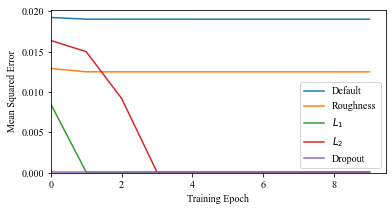

In [20]:
fig, ax = plt.subplots(1,1)

# Figure setup
fig.set_figheight(3)
fig.set_figwidth(6)

# Plotting
for hist, label in zip(hist_list, label_list):
    yplot = hist.history['mse']
    xplot = np.arange(len(yplot))
    ax.plot(xplot, yplot, label=label)

# AdaReg is Pytorch which is not a history
# ax.plot(np.arange(adareg_h.shape[0]), adareg_h[:, 0], label='AdaReg')
    
# Adjusting axis
ax.set_xlabel('Training Epoch')
ax.set_ylabel('Mean Squared Error')
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.legend()

fig.savefig("../report/project-report/figures/methodology/regularizers-preliminary-comparison.png")

plt.show()